## <center>A/B-тестирование

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-01-01 по 2023-01-07 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах, мы разбирали:
* t-тест;
* Пуассоновский бутстреп;
* тест Манна-Уитни;
* t-тест на сглаженном ctr (α=5);
* t-тест и тест Манна-Уитни поверх бакетного преобразования. 

2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
connection = {'host':'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230120',
             'user':'student',
             'password':'dpo_python_2020'
             }

In [3]:
query = '''
select exp_group, 
    user_id, 
    sum(action = 'like') likes,
    sum(action = 'view') views,
    likes/views ctr
from {db}.feed_actions 
where toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (1,2)
group by exp_group, user_id 
'''

In [4]:
df = ph.read_clickhouse(query, connection = connection)

In [5]:
df.shape

(20031, 5)

In [6]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


Посмотрим на размер групп и основные описательные статистики:

In [7]:
df[df['exp_group']==1].ctr.describe()

count    10079.000000
mean         0.215605
std          0.084160
min          0.000000
25%          0.160097
50%          0.203125
75%          0.257654
max          0.722222
Name: ctr, dtype: float64

In [8]:
df[df['exp_group']==2].ctr.describe()

count    9952.000000
mean        0.214419
std         0.144180
min         0.000000
25%         0.095238
50%         0.142857
75%         0.325000
max         0.923077
Name: ctr, dtype: float64

Количество наблюдений в каждой из выборок достаточно большое ~ 10000. **Средние у групп практически одинановые**, но вот у второй выборки (тестовой) значение стандартного отклонения составляет 3/4 от среднего, что говорит нам о большом разбросе значений наблюдений во второй группе. А если средние CTR в выборках схожи, значит скорее всего, **применение нового ML алгоритма не увеличило эту метрику.**
Продолжим исследование.

Построим гистограмму распределения значений CTR для двух групп:

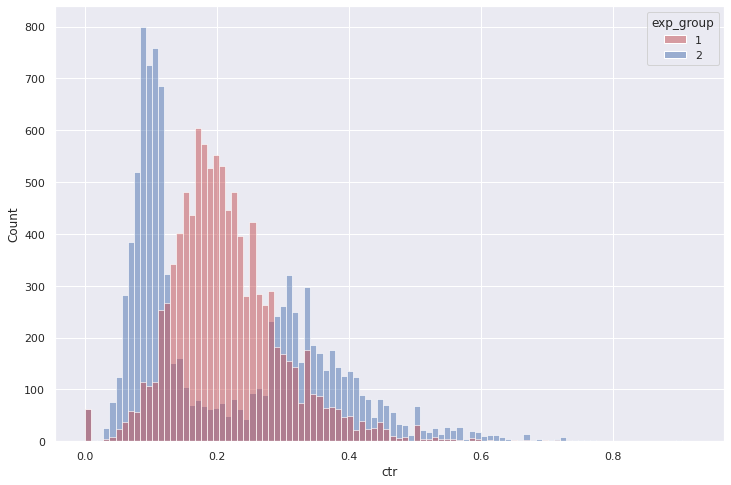

In [9]:
sns.set(rc={'figure.figsize':(12,8)})
g = sns.histplot(data = df,
                 x='ctr',
                 hue='exp_group',
                 palette = ['r', 'b'],
                 bins = 100)

Распределение CTR в первой контрольной группе напоминает нормальное, но с небольшим перекосом влево и более длинными правым хвостом.  
А вот распределение CTR во второй контрольной группе уже получилось с явной бимодальностью. Скорее всего это означает противоположность мнений по отношению к постам. Выборка не является однородной и наблюдения порождены двумя "наложенными" распределениями.   
**С такой выборкой t тест применять нельзя, так как он скорее всего не прокрасится и породит ошибку второго рода.**

Проведем в рамках эксперимента тест Стьюдента и Манна-Уитни. **Стоит учесть что гипотеза одностороняя:**

### Тест Стьюдента:

* $H_0$ - средние значения CTR в контрольной и экспериментальной группaх равны.  
* $H_1$ - средние значения CTR в тестовой группе выше, чем в контрольной.

In [10]:
stats.ttest_ind(df[df['exp_group']==1].ctr, 
                df[df['exp_group']==2].ctr, 
                equal_var=False,
                alternative='less')

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.7609688434562533)

Проверим обратную альтернативную гипотезу:  
* $H_0$  - средние значения CTR в контрольной и экспериментальной группaх равны.  
* $H_1$  - средние значения CTR в тестовой группе ниже, чем в контрольной.  

In [11]:
stats.ttest_ind(df[df['exp_group']==1].ctr, 
                df[df['exp_group']==2].ctr, 
                equal_var=False,
                alternative='greater')

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.23903115654374674)

### Тест Манна-Уитни:

- Нулевая гипотеза $H_0: P(X>Y) = P(Y>X)$

- Альтернативная гипотеза $H_1: P(X>Y) < P(Y>X)$

In [12]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                   df[df.exp_group == 1].ctr,
                   alternative='greater')

MannwhitneyuResult(statistic=43704947.5, pvalue=1.0)

Проверим обратную альтернативную гипотезу:
- Альтернативная гипотеза $H_1: P(X>Y) > P(Y>X)$

In [13]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                   df[df.exp_group == 1].ctr,
                   alternative='less')

MannwhitneyuResult(statistic=43704947.5, pvalue=3.0188242308889518e-56)

Как и ожидалось, **тест Стьюдента не прокрасился из-за заложенного в t статистику сравнения среднего выборок**, а они в двух выборках практически идентичны.  
А вот **тест Манна-Уитни** учитывает расположение элементов выборок относительно друг друга (однородность распределений), а не значения элементов. Поэтому он и не зависит от средних выборок и **показал наличие статистически значимых различий в выборках**.   

Что касается гипотезы, то подтверждается обратная альтернативная гипотеза: **вероятность получения случайного числа CTR из контрольной группы большего по значению, чем случайного числа CTR из тестовой группы выше, чем вероятность получения случайного числа CTR из контрольной группы меньшего по значению, чем случайного числа CTR из тестовой группы.**

## <center>Сглаженный CTR
Проверим качество CTR в выборках по количеству просмотров на пользователя:

In [14]:
df[df['exp_group']==2].views.describe()

count    9952.000000
mean       66.148513
std        45.151210
min         1.000000
25%        32.000000
50%        56.000000
75%        91.000000
max       321.000000
Name: views, dtype: float64

In [15]:
df[df['exp_group']==1].views.describe()

count    10079.000000
mean        66.299831
std         45.043411
min          2.000000
25%         32.000000
50%         56.000000
75%         90.000000
max        311.000000
Name: views, dtype: float64

CTR в обеих группах сильно зашумлен данными от пользователей с низким количеством просмотров. **В двух группах 75-й процентиль это ~ 90 просмотров на юзера!**.
Такого количества просмотров недостаточно для точной оценки CTR. **Применение процедуры сглаживания Лапласа к метрике CTR обосновано**.


<center>$smoothed CTR_u = \dfrac{clicks_u+\alpha*globalCTR}{views_u + \alpha}$

 

Где $\alpha$ — гиперпараметр.   

Идея проста: когда просмотров много, сглаженный CTR почти равен CTR пользователя. Когда просмотров мало, сглаженный CTR почти равен общегрупповому CTR. Иначе говоря, если у пользователя много просмотров, мы можем быть уверены, что клики / просмотры — хорошая оценка его CTR, а когда у пользователя просмотров мало, мы устанавливаем в качестве оценки общегрупповой CTR.

In [16]:
# Функция для получения сглаженного CTR:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha = 5):
    '''Гиперпараметр alpha задан по условию и равен 5'''
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [17]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [18]:
df.loc[df['exp_group'] == 1, 'smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1), axis=1)

df.loc[df['exp_group'] == 2, 'smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2), axis=1)

Построим гистограмму распределения значений CTR до и после сглаживания Лапласа:

Text(0.5, 1.0, 'CTR после сглаживания')

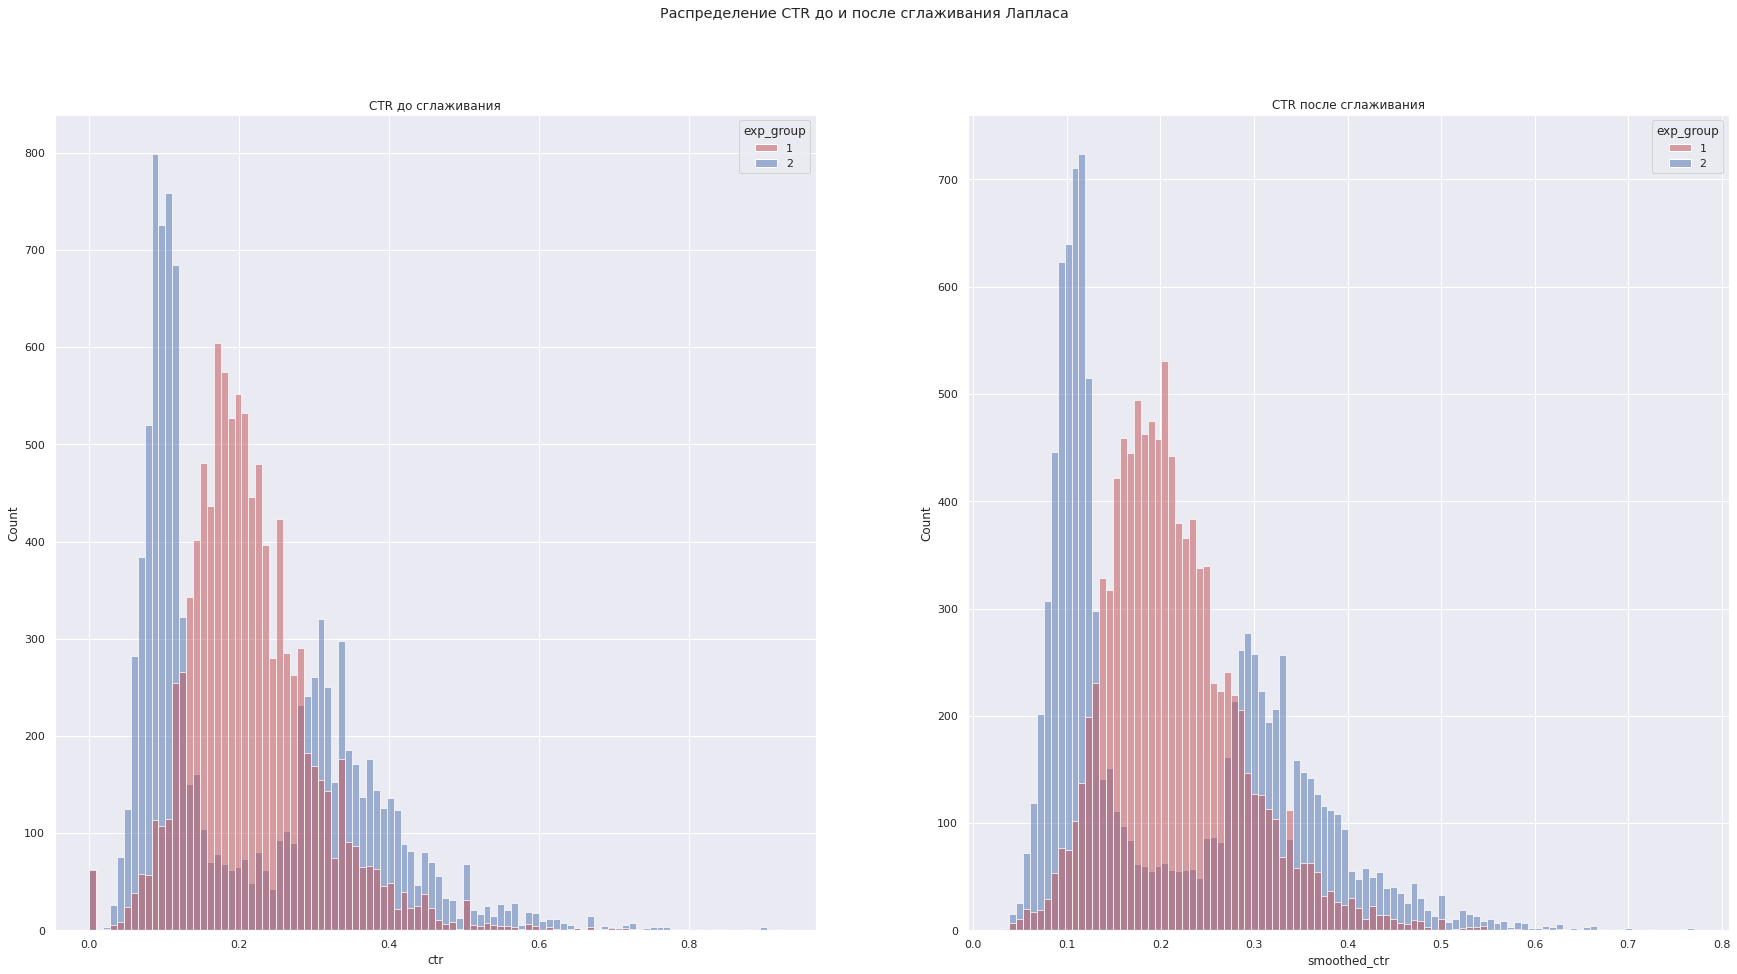

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(30,15))
fig.suptitle('Распределение CTR до и после сглаживания Лапласа')
sns.histplot(ax=axes[0],
             data = df,
             x='ctr',
             hue='exp_group',
             palette = ['r', 'b'],
             bins = 100)
axes[0].set_title('CTR до сглаживания')
sns.histplot(ax=axes[1],
             data = df,
             x='smoothed_ctr',
             hue='exp_group',
             palette = ['r', 'b'],
             bins = 100)
axes[1].set_title('CTR после сглаживания')

Заметно что пропали выбросы с нулевыми CTR, сами распределения сгладились и немного сместились влево.

### Проведем t тест Стьюдента на сглаженных CTR:
* $H_0$ - средние значения CTR в контрольной и экспериментальной группaх равны.  
* $H_1$ - средние значения CTR в тестовой группе выше, чем в контрольной.

In [20]:
stats.ttest_ind(df[df['exp_group']==2].smoothed_ctr, 
                df[df['exp_group']==1].smoothed_ctr, 
                equal_var=False,
                alternative='greater')

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.9888115092220721)

Проверим обратную альтернативную гипотезу:  
* $H_0$  - средние значения CTR в контрольной и экспериментальной группaх равны.  
* $H_1$  - средние значения CTR в тестовой группе ниже, чем в контрольной.  

In [21]:
stats.ttest_ind(df[df['exp_group']==2].smoothed_ctr, 
                df[df['exp_group']==1].smoothed_ctr, 
                equal_var=False,
                alternative='less')

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.01118849077792795)

**Тест прокрасился!**

Посмотрим, как изменилась разница среднего CTR контрольной и тестовых выборок после сглаживания:

In [22]:
mean_ctr_before = df[df['exp_group']==1].ctr.mean()-df[df['exp_group']==2].ctr.mean()
mean_ctr_after =  df[df['exp_group']==1].smoothed_ctr.mean()-df[df['exp_group']==2].smoothed_ctr.mean()
print(mean_ctr_before, mean_ctr_after)

0.0011853249381691133 0.0032859410562490754


In [23]:
mean_ctr_after / mean_ctr_before

2.7721858795315937

**Разница средних значений CTR в тестовой выборке после сглаживания Лапласа увеличилась в 2.7 раз!**

Проверим измнение стандартных отклонений:

In [24]:
print(df[df['exp_group']==1].ctr.std(), df[df['exp_group']==1].smoothed_ctr.std())

0.08415951942281481 0.07136807186660156


In [25]:
print(df[df['exp_group']==2].ctr.std(), df[df['exp_group']==2].smoothed_ctr.std())

0.14417998415658578 0.12476776857845215


После сглаживания Лапласа стандартное отклонение CTR в обеих выборках уменьшилось на ~ 15%

*Из-за увеличения разности средних в три раза и уменьшения стандартного отклонения уменьшились оценки дисперсии. Это и дало увлечение t критерия в три раза, что и снизило p value.*

**Вывод: применение сглаживания Лапласа для метрики CTR позволило увеличить чувствительность t критерия и обнаружить статистически значимую разницу в группах.**   

Однако теоретической гарантии, что его направленность совпадает с направленностью общего количества кликов, нет и применять такой метод следует только на свой страх и риск.

### Проведем Тест Манна-Уитни на сглаженных CTR:

In [26]:
stats.mannwhitneyu(df[df.exp_group == 2].smoothed_ctr,
                   df[df.exp_group == 1].smoothed_ctr,
                   alternative='greater')

MannwhitneyuResult(statistic=43381083.0, pvalue=1.0)

In [27]:
stats.mannwhitneyu(df[df.exp_group == 2].smoothed_ctr,
                   df[df.exp_group == 1].smoothed_ctr,
                   alternative='less')

MannwhitneyuResult(statistic=43381083.0, pvalue=8.081982057135114e-62)

**Вывод: Как и ожидалось, тест Манна-Уитни показал наличие статистически значимых различий в выборках сглаженных CTR.**  
Тест учитывает расположение элементов выборок относительно друг друга (однородность распределений), а не значения элементов. Поэтому **он и не зависит от изменившихся после сглаживания средних выборок** и **на чувствительность теста такое преобразование практически не повлияло.**

## <center>Непараметрический бутстреп для вычисления средних CTR

Для сравнения среднего CTR в первой(контрольной) и второй(тестовых) группах, применим непараметрический бутстреп.
Будем рандомно генировать псевдовыборки из CTR групп 1 и 2 длиной этих групп и каждую итерацию считать среднее по этим CTR и записывать их в список, на основе которых потом проведем анализ.

In [28]:
def bootstrap(series1, series2, times = 2000):
    """
    Функция bootstrap рассчитывает среднее CTR в псевдовыборке из каждой группы.
    
    Параметры на вход:
    series1 - принимает на вход вектор из первой группы
    series2 - принимает на вход вектор из второй группы
    times -  сколько раз будет генерировать псевдовыборки
    
    Возвращает два распределения средних CTR по псевдовыборкам из групп 1 и 2
    """
    list1 = []
    list2 = []
    for i in range(times):
        temp1 = series1.sample(len(series1), replace=True)
        list1.append(temp1.mean())
        
        temp2 = series2.sample(len(series2), replace=True)
        list2.append(temp2.mean())
    
    return list1, list2

In [29]:
ctr_mean_1, ctr_mean_2 = bootstrap(df[df['exp_group']==1].ctr, 
                                   df[df['exp_group']==2].ctr)

Построим гистрограммы получившихся распределений средних CTR из этих 2000 псевдовыборок из тестовой и контрольной групп.

<AxesSubplot:ylabel='Count'>

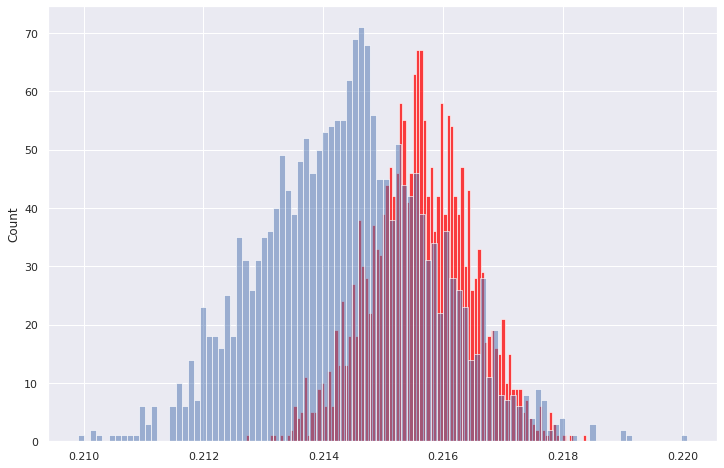

In [30]:
sns.histplot(ctr_mean_1, bins = 100,color = 'red')
sns.histplot(data = ctr_mean_2, bins = 100, alpha = 0.5)

Визуально заметно, как средние значения CTR в псевдовыборках из контрольной группы больше. Проведем тесты параметрическим методом с использованием t критерия Стьюдента и его непараметрическим аналогом - W критерием Уилкоксона в тесте Манна-Уитни .

### Тест Стьюдента:

In [31]:
stats.ttest_ind(ctr_mean_1, 
                ctr_mean_2, 
                equal_var=False,
                alternative='greater')

Ttest_indResult(statistic=32.668456488966115, pvalue=4.351713988086434e-203)

**Тест Стьюдента прокрасился**

Принимаем односторонюю гипотезу о большем значении среднего в распредлении средних CTR пседовыборок из группы 1, т.е. контрольной. Новый ML алгоритм во 2 группе привел к снижению CTR.

### Тест Манна-Уитни:

In [32]:
stats.mannwhitneyu(ctr_mean_1,
                   ctr_mean_2,
                   alternative='greater')

MannwhitneyuResult(statistic=3073508.0, pvalue=3.1310307193424063e-190)

**Тест Манна-Уитни показал наличие статистически значимых различий в выборках**.   

Принимаем гипотезу о том вероятность получения случайного числа среднего CTR из псевдовыборки контрольной группы большего по значению, чем случайного числа среднего CTR из псевдовыборки тестовой группы выше, чем вероятность получения случайного числа среденего CTR из псевдовыборки контрольной группы меньшего по значению, чем случайного числа среднего CTR из псевдовыборки тестовой группы.

**К недостатку бутсрепа можно отнести использование малореалистичного предположения о независимости перевыборок и значительные вычислительные затраты при их многократном построении.**

## <center>Пуассоновский бутстреп для подсчета разницы в CTR

- Берем выборку из группы 1 (у нас это $user\_id$ с его $views$ и $likes$)
- Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. Назовем ее $weights_1$.
- Считаем «глобальный CTR» по псевдовыборке для группы 1(контрольной): 

<center>$global CTR_1 = \dfrac{sum(clicks_1*weights_1)}{sum(views_1*weights_1)}$

- Берем выборку из группы 2 (у нас это $user\_id$ с его $views$ и $likes$)
- Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. Назовем ее $weights_2$.
- Считаем «глобальный CTR» по псевдовыборке для группы 2(тестовой): 

<center>$global CTR_2 = \dfrac{sum(clicks_2*weights_2)}{sum(views_2*weights_2)}$

- Считаем разницу между $global CTR_1 - global CTR_2$ и записываем эту разность, например, в список.  
- Повторяем процедуру много раз, например, 2000.  
- Таким образом, мы набираем распределение для разницы в глобальном CTR.

In [33]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    """
    Функция bootstrap рассчитывает глобальный CTR в псевдовыборке из каждой группы.
    
    Параметры на вход:
    likes1 - количество лайков пользователей из 1-й группы
    likes2 - количество лайков пользователей из 2-й группы
    views1 - количество просмотров пользователей из 1-й группы
    views2 - количество просмотров пользователей из 2-й группы
    
    Возвращает два распределения глобальных CTR по псевдовыборкам из групп 1 и 2
    """
    # Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку» для 1-й и 2-й группы, 
    # то есть «вес» пользователя
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    # Считаем глобальный CTR по псевдовыборке для каждой группы:
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2



In [34]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

global_ctr_1, global_ctr_2 = bootstrap(likes1, views1, likes2, views2)

Построим гистрограммы получившихся распределений глобальных CTR из этих 2000 псевдовыборок из тестовой и контрольной групп.

<AxesSubplot:ylabel='Count'>

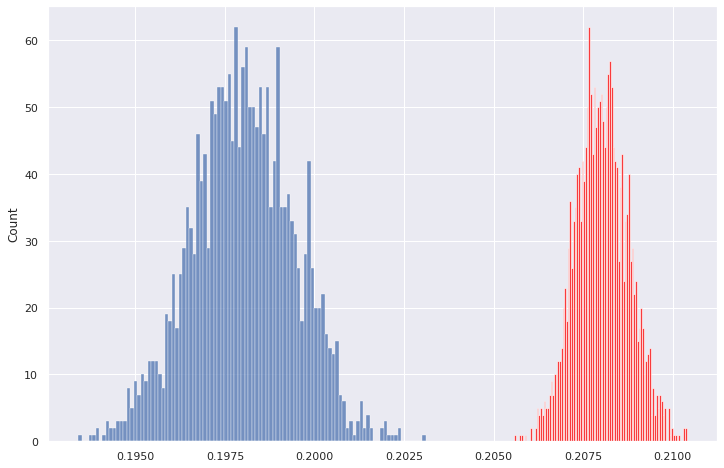

In [35]:
sns.histplot(global_ctr_1, bins = 100,color = 'red')
sns.histplot(global_ctr_2, bins = 100)

Построим гистрограмму разницы между глобальными CTR:

<AxesSubplot:ylabel='Count'>

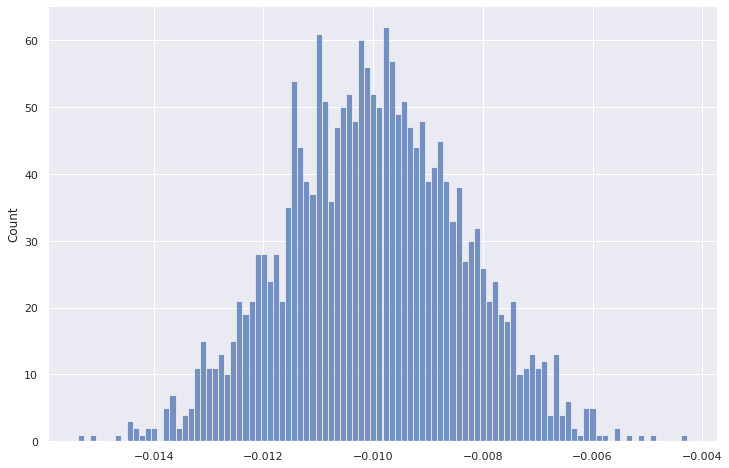

In [36]:
sns.histplot(global_ctr_2 - global_ctr_1, bins = 100)

Очевидно, что глобальные CTR в псевдовыборках из контрольной группы больше, чем в тествой, так как графики их распределений даже не пересекаются.  Можно утверждать, что новый ML алгоритм (группа 2) в тестовой группе 2 (красная на графике выше) приводит к снижению глобального CTR.   
   
**Проведем тест параметрическим методом с использованием t критерия Стьюдента.**

In [37]:
stats.ttest_ind(global_ctr_1, 
                global_ctr_2, 
                equal_var=False,
                alternative='greater')

Ttest_indResult(statistic=277.39991434317454, pvalue=0.0)

**P-value = 0, что очевидно меньше уровня значимости в 0.05. Следовательно можем принять гипотезу, что среднее значение глобальных CTR псевдовыборок контрольной группы больше, чем реднее значение глобальных CTR псевдовыборок тестовой группы.  
Новый ML алгоритм во 2 группе привел к снижению CTR.**

## <center>Тест Стьюдента и тест Манна-Уитни поверх бакетного преобразования
   

Необходимо разбить пользователей на n «корзинок» («бакетов»). Нужно гарантировать, что каждый пользователь попадет только в один бакет и пользователи по бакетам будут распределены равномерно. Это можно гарантировать с помощью того же хеширования с солью. Каждый бакет теперь становится как бы «метапользователем», участвующим в эксперименте. И внутри такого «метапользователя» показатель нужно как-то агрегировать.
Будем вычеслять среднее CTR по бакету.   

Разделим контрольные и тестовые группы по 50 бакетов и считаем в каждом бакете среднее. В итоге на выходе получим две выборки из 50 значений средних CTR по этим «метапользователям». Это как будто мы сделали бутстреп, но только не сгенерировав псевдовыборку, а откусив правильным образом кусок из имеющейся.

Разделим две группы пользователей на 50 бакетов прямо в ClickHouse с помощью функции хэширования **xxHash64**:

In [38]:
query1 = """
select 
    exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr
from 
    (
    select 
        exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    from {db}.feed_actions 
    where toDate(time) between '2023-01-01' and '2023-01-07'
          and exp_group in (1,2)
    group by exp_group, bucket, user_id
    )
group by exp_group, bucket
"""

In [39]:
df1 = ph.read_clickhouse(query1, connection = connection)

In [40]:
df1.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


In [41]:
df1.bucket.count()

100

Получено 50 бакетов в тестовой и 50 бакетов в контрольной группах

### Проведем тест параметрическим методом с использованием t критерия Стьюдента:

In [42]:
stats.ttest_ind(df1[df1['exp_group']==2].bucket_ctr, 
                df1[df1['exp_group']==1].bucket_ctr, 
                equal_var=False, 
                alternative='less')

Ttest_indResult(statistic=-5.668234732053979, pvalue=1.7227975824972953e-07)

**Тест прокрасился, p-value стремится к нулю, следовательно принимаем альтернативную гипотезу о том, что среднее значение в выборке побакетных CTR в первой (контрольной) группе выше, чем среднее значение в выборке побакетных CTR во второй (тестовой) группе.**

### Проведем тест параметрическим методом с использованием U-критерия Манна-Уитни:

In [43]:
stats.mannwhitneyu(df1[df1['exp_group']==2].bucket_ctr, 
                   df1[df1['exp_group']==1].bucket_ctr, 
                   alternative='less')

MannwhitneyuResult(statistic=505.0, pvalue=1.429981968246323e-07)

**Тест Манна-Уитни прокрасился, p-value стремится к нулю.**

**Принимаем гипотезу о том вероятность получения случайного числа среднего CTR бакета из контрольной группы большего по значению, чем случайного числа среднего CTR бакета из тестовой группы выше, чем вероятность получения случайного числа среденего CTR бакета из контрольной группы меньшего по значению, чем случайного числа среднего CTR бакета из  тестовой группы.
А это значит, что новый ML алгоритм во 2 группе привел к снижению CTR.**

## <center>Выводы:

Выполнено статистическое тестирование гипотезы о том что новый алгоритм во 2-й группе приведет к увеличению CTR с использованием параметрических и непараметричсеких методов:
- t-тест на всех группах без предобработки;
- Тест Манна-Уитни на всех группах без предобработки;
- Непараметрический бутстреп;
- Пуассоновский бутстреп;
- t-тест и тест Манна-Уитни на сглаженном ctr (α=5);
- t-тест и тест Манна-Уитни поверх бакетного преобразования.

По результатам выполнения серии тестов, данная гипотеза была отвергнута и принята обратная: новый ML алгоритм в тестовой группе приведет к снижению CTR по сравнению с CTR в контрольной.
Однако не все тесты обнаружили статистически значимое различие в группах.

Тест Стьюдента на группах без предобработки не прокрасился из-за заложенного в t статистику сравнения среднего выборок, а они в двух выборках практически идентичны. Но после применения сглаживания Лапласа для метрики CTR, которое позволило увеличить чувствительность t критерия, была обнаружена статистически значимая разница в группах и принята обратная альтернативная гипотеза:   
Cредние значения CTR в тестовой группе ниже, чем в контрольной.

Рекоммендация: Не раскатывать алгоритм на всех пользователей. Во-первых, потому что пуассоновский бутстреп показал, что СTR в таргет группе стал ниже, чем в контрольной группе. Во-вторых, стоит также разобраться, почему CTR стал бимодальным.

## <center> Анализ причин бимодальности распределения CTR в тестовой группе

Бимодальность распределения в нашем случае говорит о том что сформировалось две подгруппы пользователей и одной группы CTR вырос по отношению к контрольной, а у второй подгруппы CTR стал ниже. 

Почему так произошло?

Одна из причин - бимодальность распределения CTR в тестовой группе присутствовала и ранее.
Проверим распредление CTR на логах за 11 дней до применения  нового ML алгоритма:

In [44]:
query = '''
select user_id,
    sum(action = 'like')/sum(action = 'view') ctr
from {db}.feed_actions 
where toDate(time) between '2022-12-20' and '2022-12-31'
    and exp_group in (2)
group by user_id 
'''

In [45]:
df = ph.read_clickhouse(query, connection = connection)

In [46]:
df.head()

,user_id,ctr
0,129127,0.134831
1,129711,0.300000
2,114145,0.218310
3,22116,0.219178
4,21676,0.220779


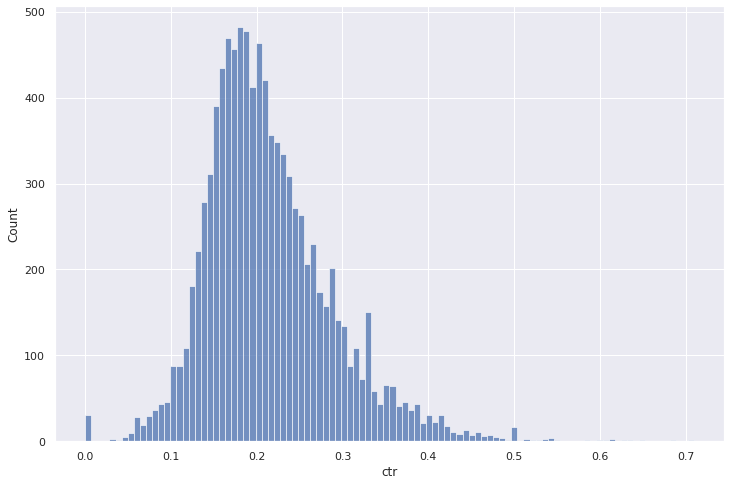

In [47]:
sns.set(rc={'figure.figsize':(12,8)})
g = sns.histplot(data = df,
                 x='ctr',
                 bins = 100)

Гистрограмма распределения CTR в тестовой группе до применения алгоритма,  позволяет утверждать об отсутствии бимодальности распредления до его применения. Отвергаем данную теорию.

Вероятно, пользователей в каждой из подгрупп (те кому новый алгоритм предлагал интересные для них посты и те кому новые посты не нравились) что-то объединяет.

In [48]:
query = '''
select exp_group, 
    user_id, 
    gender,
    age,
    sum(action = 'like') likes,
    sum(action = 'view') views,
    likes/views ctr
from {db}.feed_actions 
where toDate(time) between '2023-01-01' and '2023-01-07'
    and exp_group in (1,2)
group by exp_group, user_id, gender, city, age
'''

In [49]:
df = ph.read_clickhouse(query, connection = connection)

Разобъем тестовую группу на две: с низким CTR и высоким CTR. Пороговое значение для CTR ддя разбиения: 0.2 так как на гистограмме при этом значении CTR, одно распеределение перетекает в другое и преваращается в бимодальное.

In [50]:
gr1 = df.loc[(df['exp_group'] == 2)&(df['ctr'] < 0.2)]
gr2 = df.loc[(df['exp_group'] == 2)&(df['ctr'] >= 0.2)]

Проверим возраст и пол в подгруппах:

In [51]:
stats.mannwhitneyu(gr1.age, 
                   gr2.age)

MannwhitneyuResult(statistic=12196503.0, pvalue=0.7059764160346121)

In [52]:
stats.mannwhitneyu(gr1.gender, 
                   gr2.gender)

MannwhitneyuResult(statistic=12361145.0, pvalue=0.3662478744046721)

Различия по возрасту и полу статистически незначимы между пользователями, у которых низкий и высокий CTR.

Проверим лайки просмотры:

In [53]:
gr1.likes.describe()

count    5486.000000
mean        7.456981
std         5.734181
min         0.000000
25%         3.000000
50%         6.000000
75%        11.000000
max        39.000000
Name: likes, dtype: float64

In [54]:
gr1.views.describe()

count    5486.000000
mean       71.911775
std        47.789918
min         1.000000
25%        35.000000
50%        62.000000
75%        99.000000
max       321.000000
Name: views, dtype: float64

In [55]:
gr2.likes.describe()

count    4466.000000
mean       20.034931
std        13.590496
min         1.000000
25%        10.000000
50%        17.000000
75%        27.000000
max        95.000000
Name: likes, dtype: float64

In [56]:
gr2.views.describe()

count    4466.000000
mean       59.068966
std        40.581740
min         5.000000
25%        28.000000
50%        49.000000
75%        80.000000
max       275.000000
Name: views, dtype: float64

In [57]:
stats.mannwhitneyu(gr1.likes, 
                   gr2.likes)

MannwhitneyuResult(statistic=4147604.5, pvalue=0.0)

In [58]:
stats.mannwhitneyu(gr1.views, 
                   gr2.views,
                   alternative='greater')

MannwhitneyuResult(statistic=14195208.0, pvalue=1.0896160060083045e-42)

Из описательных статистик распределений лайков и просмотров и проведенных тестов, видно статистическое отличие в количестве просмотров и лайков в подгруппах:   
**У тех кому новый ML алгоритм "не зашел" увеличись просмотры, а вот лайки естественно упали, что и дало снижение CTR.**

## <center>Финальная рекомендация:

По результатам AB-теста проведенному с примением параметрических и непараметрических методов гипотеза о том, что новый ML алгоритм приведет к увеличению CTR в тестовой группе была опровергнута.
В тестовой группе обнаружена бимодальность распределения CTR, после анализа которого определены две подгруппы пользователей: те кому новый алгоритм предлагал интересные посты и тем кому новый ML алгоритм "не зашел", причем пользователей которые новые посты не оценили больше. Это и дало снижение CTR.  
   
**Вероятно, ML модель не обладает достаточной точностью.**  

**Новый алгоритм на всех новых пользователей раскатывать не стоит.**


